In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as scs
from yahoofinancials import YahooFinancials
import ray
import os
from timebudget import timebudget
import seaborn as sns
import pickle

C:\Users\Ferhat\Anaconda3\envs\py39\lib\site-packages\redis\connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


In [ ]:
from datetime import date
today = date.today()

Dowload or save dataframe from Pickle to minimise API requests

In [ ]:
#df.to_pickle('ferhat_portfolio.p')
df = pd.read_pickle('ferhat_portfolio.p')

Download stock data using two different methods

In [3]:
#stock = "SMT.L SGLN.L CMCX.L GHH.L 0P00000QW9.L GSK.L RIO.L BATG.L BA.L ROBG.L CSWU.L HMCH.L AAL.L BATS.L IAG.L HTRY.L RR.L KLWD.L 0P00000QWT.L JUP.L HTWN.L PHAG.L CDGP.AQ BOO.L"
stock2 = ['SMT.L', 'SGLN.L', 'CMCX.L', 'GHH.L', '0P00000QW9.L', 'GSK.L', 'RIO.L', 'BATG.L', 'BA.L', 'ROBG.L', 'CSWU.L', 'HMCH.L', 'AAL.L', 'BATS.L', 'IAG.L', 'HTRY.L', 'RR.L', 'KLWD.L', '0P00000QWT.L', 'JUP.L', 'HTWN.L', 'PHAG.L', 'CDGP.AQ', 'BOO.L']

date_start = '2017-01-01'
date_end = today.strftime("%Y-%m-%d")
time_interval = ['daily', 'weekly','monthly'][0]

In [4]:
data = yf.download(stock, start=date_start, end=date_end)

[*********************100%***********************]  24 of 24 completed


In [5]:
data_close = data['Adj Close']

<AxesSubplot:xlabel='Date'>

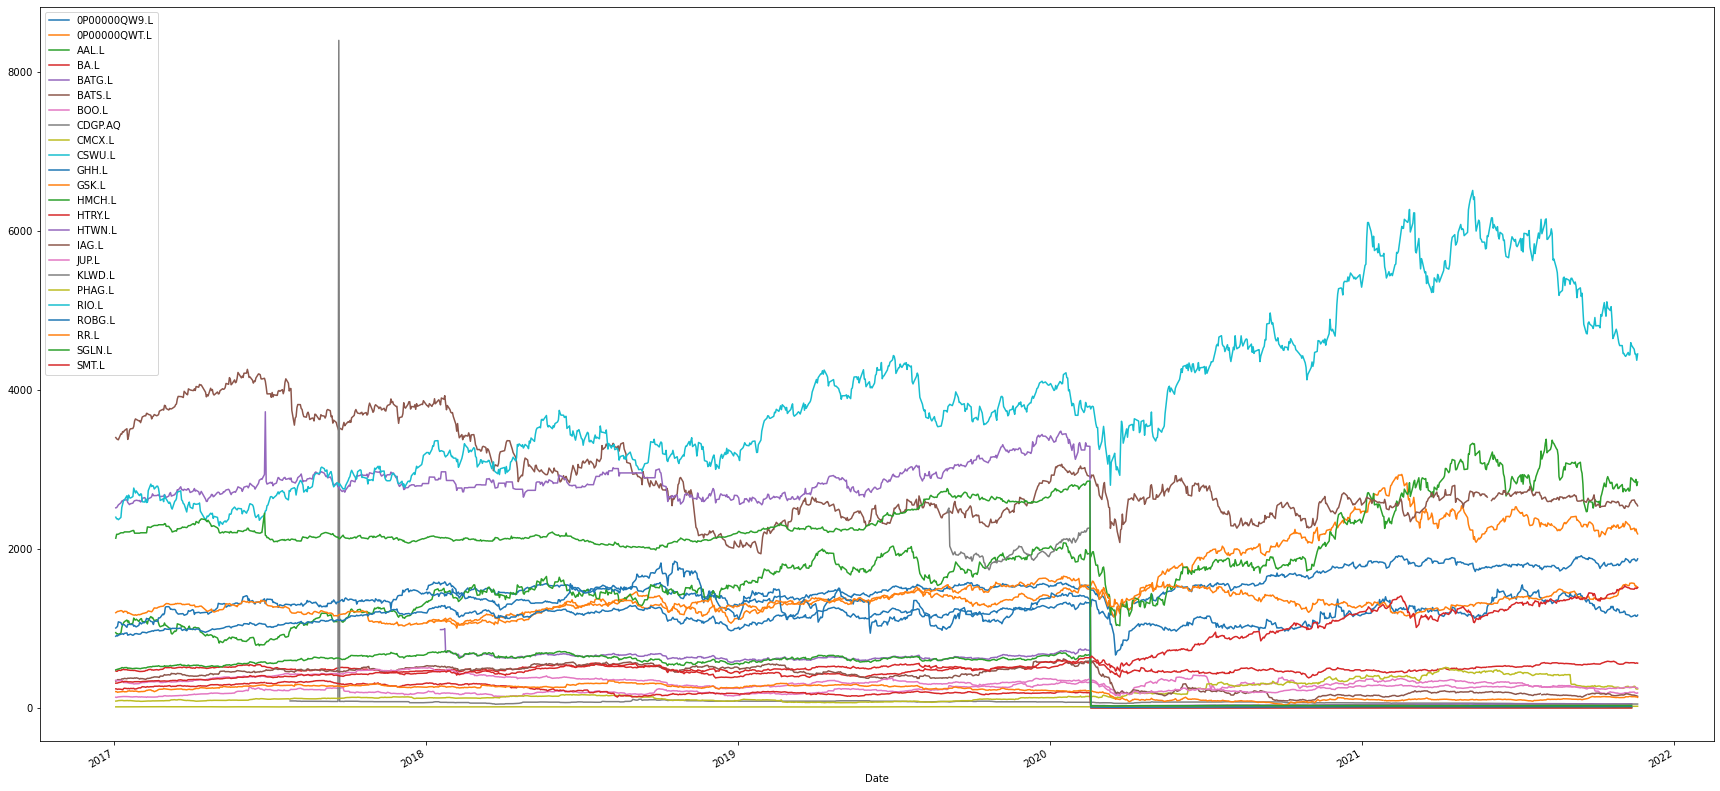

In [6]:
data_close.plot(figsize=(30,15))

Use Moustafa method as in here: https://github.com/msh855/Medium_repo/blob/main/How_to_Download_Stock_prices_faster.ipynb

In [7]:
@ray.remote
def get_stock_data(ticker, start_date, end_date, time_interval):
    yahoo_financials = YahooFinancials(ticker)
    data = yahoo_financials.get_historical_price_data(start_date= start_date, 
                                                      end_date=end_date, 
                                                      time_interval=time_interval)
    # to get short name and type 
    temp = yahoo_financials.get_stock_quote_type_data()
    
    df_temp = pd.DataFrame(data[ticker]['prices'])
    
    # fix faulty yahoo data that jumps 100x
    jumps_up   = df_temp['adjclose'] / df_temp['adjclose'].shift() >  50
    jumps_down = df_temp['adjclose'] / df_temp['adjclose'].shift() < .02
    correction_factor = 100.**(jumps_down.cumsum() - jumps_up.cumsum())
    df_temp['adjclose'] *= correction_factor
    
    df_temp['Stock'] = temp[ticker]['shortName']
    df_temp['Type'] = temp[ticker]['quoteType']
    
    # use yahoo finance to get other information 
    tik_info = yf.Ticker(ticker)
    info = tik_info.info
    if "sector" in info:
        df_temp['Sector'] = info["sector"]
    else: 
        df_temp['Sector'] = 'unclassified'
            
    return df_temp


ray.init(ignore_reinit_error=True, num_cpus=6)
@timebudget
def download_my_stocks(operation, input):
    mydata = ray.get([operation.remote(ticker,date_start,date_end, time_interval) for ticker in input]) 
    return mydata

mydata=download_my_stocks(get_stock_data, stock2)
#ray.shutdown()

df = pd.concat(mydata)
df = df.rename(columns={'formatted_date':'Date'})
df = df.drop('date', axis = 1)
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df = df.set_index('Date')
df.head()

download_my_stocks took 42.026sec


,high,low,open,close,volume,adjclose,Stock,Type,Sector
Date,,,,,,,,,
2017-01-03,322.399994,319.427002,322.399994,322.000000,1671071.0,313.748962,SCOTTISH MORTGAGE INVESTMENT TR,EQUITY,unclassified
2017-01-04,322.500000,320.600006,322.000000,321.799988,1171663.0,313.554016,SCOTTISH MORTGAGE INVESTMENT TR,EQUITY,unclassified
2017-01-05,324.399994,319.500000,319.500000,323.000000,1600422.0,314.723328,SCOTTISH MORTGAGE INVESTMENT TR,EQUITY,unclassified
2017-01-06,328.299988,323.100006,323.500000,328.299988,1685091.0,319.887421,SCOTTISH MORTGAGE INVESTMENT TR,EQUITY,unclassified
2017-01-09,336.000000,329.100006,329.200012,334.500000,2486622.0,325.928558,SCOTTISH MORTGAGE INVESTMENT TR,EQUITY,unclassified


In [8]:
df.tail()

,high,low,open,close,volume,adjclose,Stock,Type,Sector
Date,,,,,,,,,
2021-11-15,203.899994,199.300003,202.000000,202.699997,9529979.0,202.699997,BOOHOO GROUP PLC ORD 1P,EQUITY,Consumer Cyclical
2021-11-16,204.800003,190.649994,204.800003,191.199997,7080290.0,191.199997,BOOHOO GROUP PLC ORD 1P,EQUITY,Consumer Cyclical
2021-11-17,194.300003,188.550003,191.050003,192.000000,5329153.0,192.000000,BOOHOO GROUP PLC ORD 1P,EQUITY,Consumer Cyclical
2021-11-18,193.384003,183.800003,192.500000,184.350006,7312798.0,184.350006,BOOHOO GROUP PLC ORD 1P,EQUITY,Consumer Cyclical
2021-11-19,191.550003,183.899994,186.100006,191.300003,5134157.0,191.300003,BOOHOO GROUP PLC ORD 1P,EQUITY,Consumer Cyclical


In [15]:
df = df.reset_index()

Check data in Seaborn Lineplot

(0.0, 10000.0)

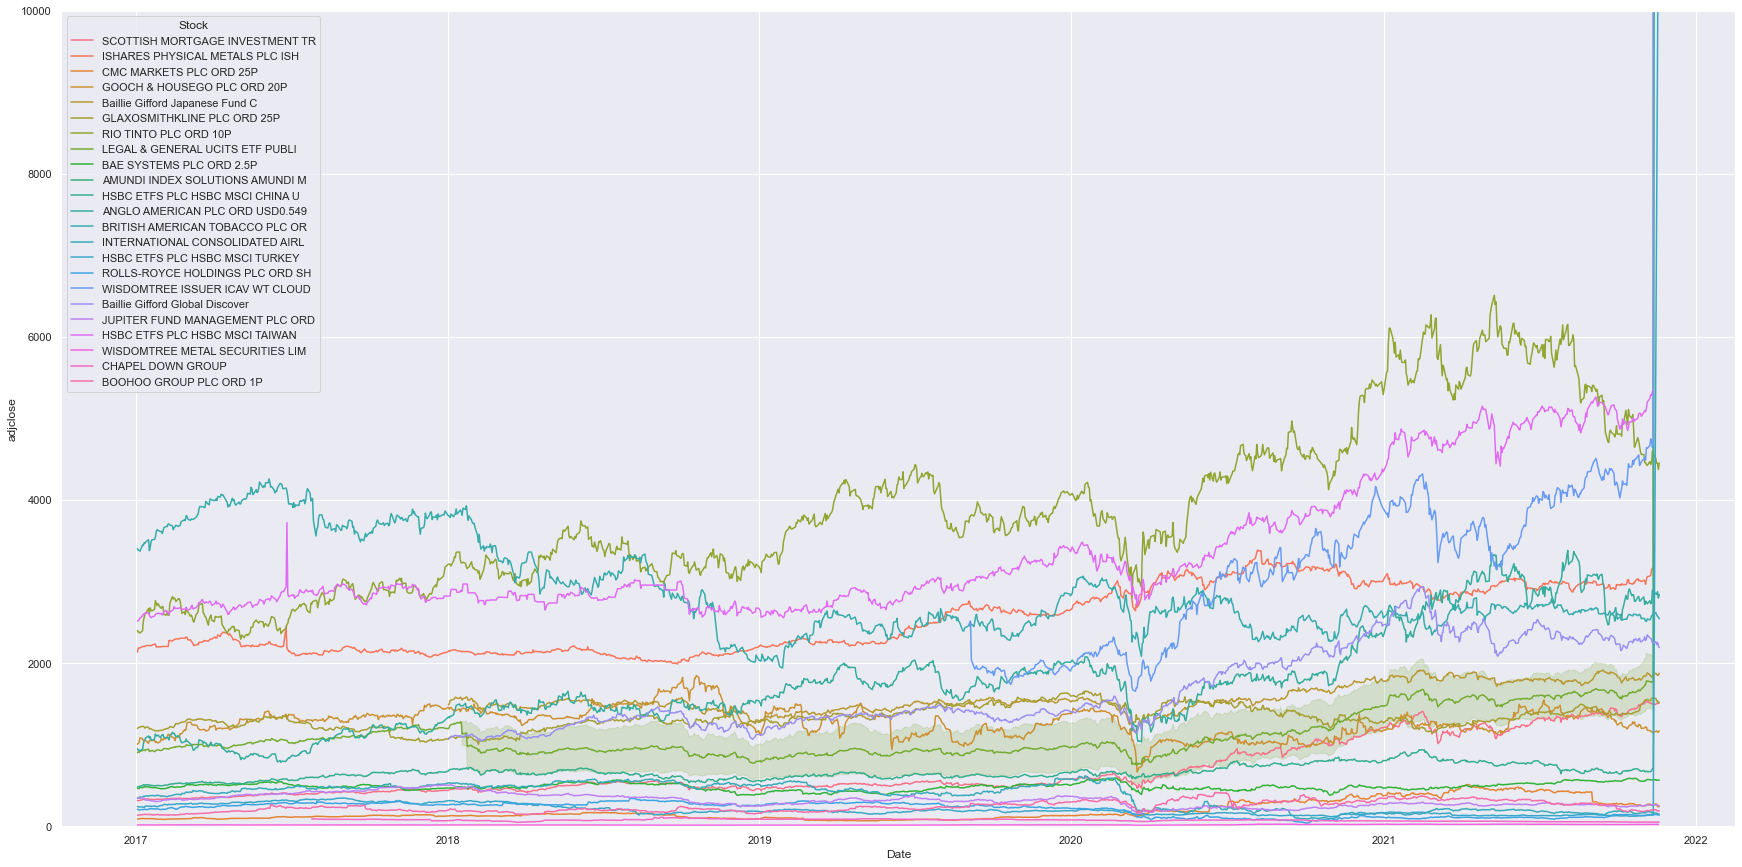

In [27]:
sns.set(rc={'figure.figsize':(30,15)})
sns.lineplot(data = df, x='Date', y='adjclose', hue = 'Stock')
plt.ylim(0, 10000)

Lets try Plotly

In [6]:
import plotly.express as px

fig = px.line(df, x="Date", y="adjclose", color='Stock')
fig.show()